In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from PIL import Image
from skimage.draw import polygon as sk_polygon
from cv2 import fillPoly, fillConvexPoly

In [3]:
%load_ext rich
%load_ext autoreload
%autoreload 1

In [4]:
from mbrl.environments.tangram.tangram import Tangram
%aimport mbrl.environments.tangram.tangram

---

In [5]:
HOUSE = np.array([[0.505, 0.49333333], [0.63, 0.36833333], [0.38, 0.36833333], [0.4625, 0.62083333], [0.5875, 0.49583333], [0.3375, 0.49583333], [0.63166667, 0.49416667], [0.63166667, 0.36916667], [0.50666667, 0.49416667], [0.441, 0.43133333], [0.3785, 0.49383333], [0.5035, 0.49383333], [0.44016667, 0.4305], [0.37766667, 0.368], [0.37766667, 0.493], [0.50030583, 0.58530583], [0.50030583, 0.67369417], [0.58869417, 0.67369417], [0.58869417, 0.58530583], [0.5885, 0.58469417], [0.50011165, 0.58469417], [0.5885, 0.49630583], [0.67688835, 0.49630583]])
TREE = np.array([[0.50392557, 0.50607443], [0.32714887, 0.50607443], [0.50392557, 0.68285113], [0.50607443, 0.50607443], [0.50607443, 0.68285113], [0.68285113, 0.50607443], [0.41, 0.49392557], [0.49838835, 0.40553722], [0.32161165, 0.40553722], [0.50553722, 0.40753722], [0.50553722, 0.49592557], [0.59392557, 0.40753722], [0.50446278, 0.49446278], [0.50446278, 0.40607443], [0.41607443, 0.49446278], [0.45580583, 0.31580583], [0.45580583, 0.40419417], [0.54419417, 0.40419417], [0.54419417, 0.31580583], [0.6, 0.49419417], [0.51161165, 0.49419417], [0.6, 0.40580583], [0.68838835, 0.40580583]])

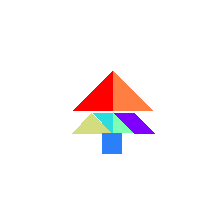

In [6]:
tangram = Tangram(x_size=12, x_step=3, max_dist=-1)  # staging_boundaries=[[0, 0], [0.6, 0.6]])  # control_boundaries=[[0, 0], [0.5, 0.5]]
# triangle-large-red triangle-large-orange triangle-medium-yellow triangle-small-lightgreen triangle-small-darkgreen square-small-blue parallelogram-small-purple
tangram.positions = [(0.445, 0.565), (0.565, 0.565), (0.41, 0.435), (0.535, 0.437), (0.475, 0.465), (0.5, 0.36), (0.6, 0.45)]
tangram.angles = [0.5, 0., -0.75, 0., 1, 0., 0.75]
tangram.flips = [0, 0, 0, 0, 0, 0, 1]
tangram.mask()
tangram.checkpoint()
tangram.reorder()
# tangram.reset()
# tangram

---

In [7]:
%%timeit
tangram.render_image(fast=False)

14.7 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
tangram.render_image()

350 µs ± 4.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---

In [9]:
xy2rc = lambda xy, shape: np.floor(xy * shape[-2::-1]).astype(int) * [1, -1] + [0, shape[0] - 1]

### Matplotlib

In [10]:
%%timeit
img = tangram.render(fast=False)
# Image.fromarray(img)

14.4 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
img = tangram.render(fast=False, color=False)
# Image.fromarray(img)

14.2 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### scikit-image

In [12]:
%%timeit
img = np.full((size := 224, size, 3), 255)
for polygon in tangram:
    img[(*sk_polygon(*xy2rc(polygon.vertices, shape=img.shape[:-1]).T[::-1], img.shape),)] = polygon.color
# Image.fromarray(img.astype(np.uint8))

1.08 ms ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    img[(*sk_polygon(*xy2rc(polygon.vertices, shape=img.shape[:-1]).T[::-1], img.shape),)] = polygon.color
# Image.fromarray(img)

1.03 ms ± 9.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
img = np.full((size := 224, size, 3), 255)
for polygon in tangram:
    # img[(*sk_polygon(*xy2rc(polygon.vertices, shape=img.shape[:-1]).T[::-1], img.shape),)] = polygon.color
    cc, rr = sk_polygon(*(polygon.vertices * img.shape[:-1]).T, img.shape)
    img[size - rr, cc] = polygon.color
# Image.fromarray(img.astype(np.uint8))

1.03 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    # img[(*sk_polygon(*xy2rc(polygon.vertices, shape=img.shape[:-1]).T[::-1], img.shape),)] = polygon.color
    cc, rr = sk_polygon(*(polygon.vertices * img.shape[:-1]).T, img.shape)
    img[size - rr, cc] = polygon.color
# Image.fromarray(img)

978 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### OpenCV

#### Colored

In [16]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    fillPoly(img, [xy2rc(polygon.vertices, shape=img.shape[:-1])], color=polygon.color)
# Image.fromarray(img)

90 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    fillConvexPoly(img, xy2rc(polygon.vertices, shape=img.shape[:-1]), color=polygon.color)
# Image.fromarray(img)

86.8 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    # fillPoly(img, [xy2rc(polygon.vertices, shape=img.shape[:-1])], color=polygon.color)
    fillPoly(img, [[0, size] + (polygon.vertices * [size, -size]).astype(int)], color=polygon.color)
# Image.fromarray(img)

68.2 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


> Winner (below) - Colored

In [19]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
for polygon in tangram:
    # fillPoly(img, [xy2rc(polygon.vertices, shape=img.shape[:-1])], color=polygon.color)
    fillConvexPoly(img, [0, size] + (polygon.vertices * [size, -size]).astype(int), color=polygon.color)
# Image.fromarray(img)

66.3 µs ± 855 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Grayscale

In [20]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
fillPoly(img, [xy2rc(polygon.vertices, shape=img.shape) for polygon in tangram.polygons], color=0)
# Image.fromarray(img)

78.4 µs ± 981 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
img = np.full((size := 224, size), 255, dtype=np.uint8)
fillPoly(img, [xy2rc(polygon.vertices, shape=img.shape) for polygon in tangram.polygons], color=0)
# Image.fromarray(img)

71.4 µs ± 414 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
%%timeit
img = np.full((size := 224, size, 3), 255, dtype=np.uint8)
fillPoly(img, [[0, size] + (polygon.vertices * [size, -size]).astype(int) for polygon in tangram.polygons], color=0)
# Image.fromarray(img)

57.7 µs ± 493 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


> Winner (below) - Grayscale

In [23]:
%%timeit
img = np.full((size := 224, size), 255, dtype=np.uint8)
fillPoly(img, [[0, size] + (polygon.vertices * [size, -size]).astype(int) for polygon in tangram.polygons], color=0)
# Image.fromarray(img)

52.2 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
